# Setting up a latent function Gaussian Process

Let us start by importing Turing.jl, the library we will use to write our statistical model and our GaussianProcess.jl package. \
The rest of the imports will only be used to generate the data and plot. 

In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using Interpolations
using GaussianProcess

### 1. Make some fake data
This time we will apply a non-linear transformation to our data.

In [2]:
function make_mean(X)
    return @.(exp(-X) + 0.1*log(1+X))
end

function make_non_lin(X)
    return @. exp(-X + X^2)
end

make_non_lin (generic function with 1 method)

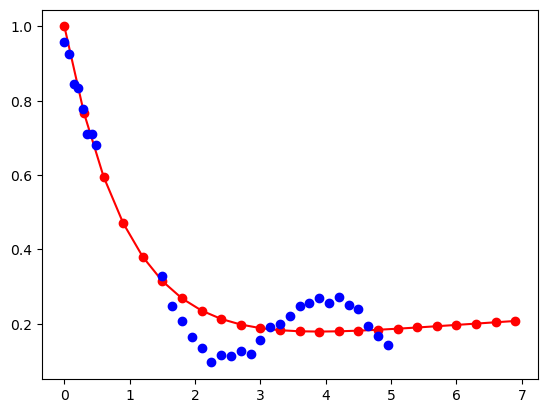

In [3]:
data_1_x = Vector(0:0.07:0.5)
data_2_x = Vector(1.5:0.15:5)
data_x = [data_1_x; data_2_x]
true_nodes = similar(data_x)
true_nodes[1:length(data_1_x), 1] = make_mean(data_1_x) .* (1 .+ randn(length(data_1_x)) .* 0.03)
true_nodes[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = make_mean(data_2_x) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))

gp_x = Vector(0:0.3:7)
plt.errorbar(data_x, true_nodes, fmt="bo")
plt.plot(gp_x, make_mean(gp_x), "ro-");

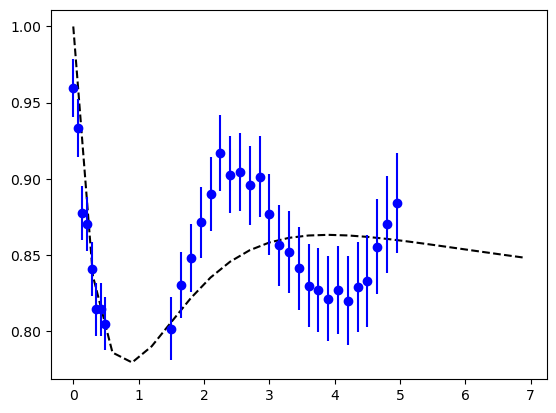

In [4]:
data = make_non_lin(true_nodes)
data_err = @.((0.02 * data) + (0.003 * data_x))

N = length(data_err) 
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

plt.plot(gp_x, make_non_lin(make_mean(gp_x)), "k--")
plt.errorbar(data_x, data, yerr=data_err, fmt="bo");

In [5]:

function posterior_predict2(X_new, X_old, mean_new, mean_old, data, cov_fn;
                            data_cov=nothing)
    if data_cov == nothing
        data_cov = zeros(length(X_new), length(X_new))
    end
    M = size(X_new, 1)
    Z = [X_new; X_old]
    return (;kwargs...) -> let
        K = sqexp_cov_fn(Z; kwargs...)
        Koo = K[(M+1):end, (M+1):end] + data_cov
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        println(Koo)
        println(Kno)
        Koo_inv = inv(Koo)
        C = Kno * Koo_inv
        m = C * (data - mean_old) + mean_new
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        return MvNormal(m, S)
    end
end

posterior_predict2 (generic function with 1 method)

### 2. Check what our priors look like

In [6]:
function model_latent_GP(eta, l, v; 
                         X=gp_x, data_cov=data_cov)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(X; eta=eta, l=l)
    mean = make_mean(X)
    gp = latent_GP(mean, v, kernel)
    y =  conditional(X, data_x, gp, sqexp_cov_fn;
                     eta=eta, l=l)
    non_lin_y = make_non_lin(y)
    return gp, y, non_lin_y
end

model_latent_GP (generic function with 1 method)

In [7]:
N_samples = 100
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
non_lin_ys=zeros(N_samples, 32)
for i in 1:N_samples
    eta = rand(Uniform(0., 0.1))
    l = rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(length(gp_x)), ones(length(gp_x))))
    gps[i, :], ys[i, :], non_lin_ys[i,:] = model_latent_GP(eta, l, v)
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
non_lin_y_m, non_lin_y_s = mean(non_lin_ys, dims=1), std(non_lin_ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

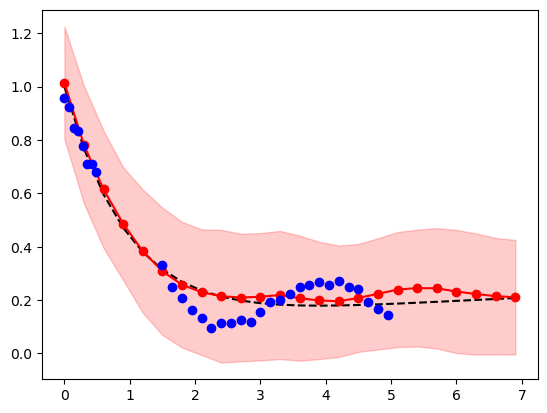

In [8]:
plt.errorbar(data_x, true_nodes, fmt="bo", label="Data")
plt.plot(gp_x, make_mean(gp_x), "k--", label="LCDM")
plt.plot(gp_x, vec(gp_m), "ro-")
plt.fill_between(gp_x, vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red");

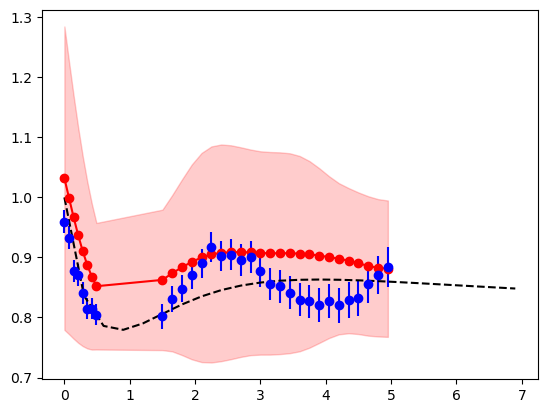

In [9]:
plt.errorbar(data_x, data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, make_non_lin(make_mean(gp_x)), "k--", label="LCDM")
plt.plot(data_x, vec(non_lin_y_m), "ro-")
plt.fill_between(data_x, vec(non_lin_y_m .+ non_lin_y_s),
                 vec(non_lin_y_m .- non_lin_y_s), alpha=0.2, color="red")
#plt.xlim(-0.1, 5.1)
#plt.ylim(-0.5, 1.7);

### 3. Define our statistical model

In [10]:
@model function stats_model(y, X; data_x=data_x, data_cov=data_cov)
    # Priors.
    eta ~ Uniform(0.0, 0.1)
    l ~ Uniform(0.1, 3)
    v ~ MvNormal(zeros(length(X)), ones(length(X)))
    kernel = sqexp_cov_fn(X, eta=eta, l=l)
    mean = make_mean(X)
    gp = latent_GP(mean, v, kernel)
    m = conditional(X, data_x, gp, sqexp_cov_fn; eta=eta, l=l)
    y ~ MvNormal(make_non_lin(m), data_cov)
end

stats_model (generic function with 2 methods)

### 4. Sample the model

In [19]:
chain = sample(stats_model(data, gp_x), HMC(0.005, 100), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:02:59


Chains MCMC chain (500×35×1 Array{Float64, 3}):

Iterations        = 1:1:500
Number of chains  = 1
Samples per chain = 500
Wall duration     = 180.17 seconds
Compute duration  = 180.17 seconds
parameters        = eta, l, v[1], v[2], v[3], v[4], v[5], v[6], v[7], v[8], v[9], v[10], v[11], v[12], v[13], v[14], v[15], v[16], v[17], v[18], v[19], v[20], v[21], v[22], v[23], v[24]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

         eta    0.0228    0.0226     0.0010    0.0037   19.7057    1.0127      ⋯
           l    1.1861    0.8219     0.0368    0.1603    4.4247    1.2372      ⋯
        v[1]    0.1074    0.5011     0.0224    0.0721   64.0655    0.9992      ⋯
        v[2]   -0.2435    0.8892     0.0398    0.1

### 5. Check how our posteriors look like

In [20]:
eta_p = group(chain, :eta).value.data[:, :, 1]
l_p = group(chain, :l).value.data[:, :, 1]
v_p = group(chain, :v).value.data[:, :, 1]

500×24 Matrix{Float64}:
  2.13904     4.35722    5.26674   …   1.15527     0.187317     0.675754
  1.48267     3.76335    4.56048       0.837329    0.535142     1.25803
  0.825779    4.04952    4.30393       0.721575    0.365631     1.33941
  0.881041    3.58901    3.91822       0.559185    0.00353109   0.51659
  0.0567637   3.10683    4.31774      -0.345515    0.698294     1.5402
  0.16096     2.44157    2.7742    …   0.305028    0.930165     1.62555
  0.345165    1.65831    2.15336       0.97031     1.2567       1.80985
  0.417771    1.33088    1.49814       0.0536085   1.92767      1.551
  0.909825    1.12394    1.76795      -0.446932    2.23138      1.38192
  0.46085     0.957485   1.37902      -0.0892421   3.60902      1.27968
  0.831727    0.813924   1.8353    …  -1.40433     1.97141      1.33171
  1.06877     0.503025   2.32355      -1.39634     2.31038      1.37035
  1.55398    -0.0282121  3.0241       -1.44198     1.94102      1.71905
  ⋮                                ⋱      

In [21]:
N_samples = length(eta_p)
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
non_lin_ys=zeros(N_samples, 32)
for i in 1:N_samples
    gps[i, :], ys[i, :], non_lin_ys[i, :] = model_latent_GP(eta_p[i], l_p[i], v_p[i, :])
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
non_lin_y_m, non_lin_y_s = mean(non_lin_ys, dims=1), std(non_lin_ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

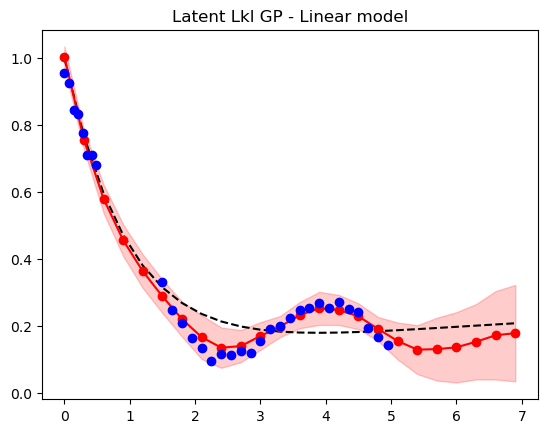

In [22]:
plt.errorbar(data_x, true_nodes, fmt="bo", label="Data")
plt.plot(gp_x, make_mean(gp_x), "k--", label="LCDM")
plt.plot(gp_x, vec(gp_m), "ro-")
plt.fill_between(gp_x, vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red");
plt.title("Latent Lkl GP - Linear model");

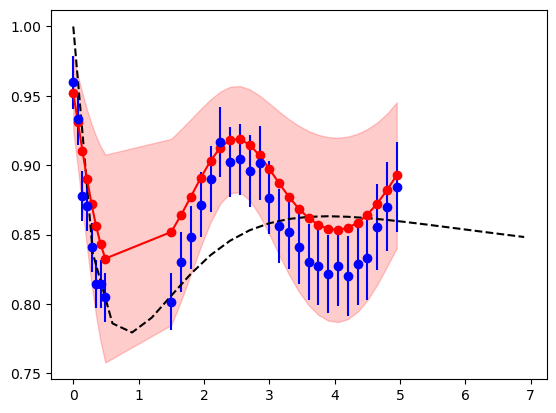

In [23]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(gp_x), make_non_lin(make_mean(gp_x)), "k--", label="LCDM")
plt.plot(vec(data_x), vec(non_lin_y_m), "ro-")
plt.fill_between(vec(data_x), vec(non_lin_y_m .+ non_lin_y_s),
                 vec(non_lin_y_m .- non_lin_y_s), alpha=0.2, color="red");

### 6. GP gradients

In [24]:
function make_mean_grad(X)
    return @.(-exp(-X) + 0.1/(1+X))
end

function model_GP_grad(eta, l, v; 
                         X=gp_x, data_cov=data_cov)
    # Dimensions of predictors .
    kernel = sqexp_cov_grad(X; eta=eta, l=l)
    mean = make_mean_grad(X)
    gp = latent_GP(mean, v, kernel)
    y =  conditional(X, data_x, gp, sqexp_cov_grad;
                     eta=eta, l=l)
    non_lin_y = make_non_lin(y)
    return gp, y, non_lin_y
end

model_GP_grad (generic function with 1 method)

In [25]:
N_samples = length(eta_p)
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
non_lin_ys=zeros(N_samples, 32)
for i in 1:N_samples
    gps[i, :], ys[i, :], non_lin_ys[i, :] = model_GP_grad(eta_p[i], l_p[i], v_p[i, :])
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
non_lin_y_m, non_lin_y_s = mean(non_lin_ys, dims=1), std(non_lin_ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

LoadError: UndefVarError: sqexp_cov_grad not defined

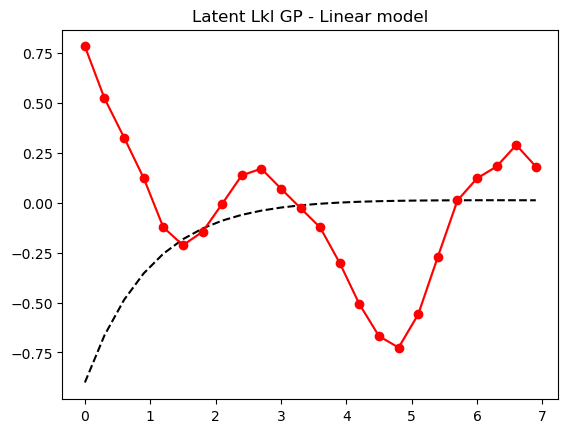

In [18]:
#plt.errorbar(data_x, true_nodes, fmt="bo", label="Data")
plt.plot(gp_x, make_mean_grad(gp_x), "k--", label="LCDM")
plt.plot(gp_x, vec(gp_m), "ro-")
plt.fill_between(gp_x, vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red");
plt.title("Latent Lkl GP - Linear model");